In [ ]:
!pip install torchvision
!pip install wandb

### Dependencies

In [29]:
import itertools
import torch
from torch import nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda import amp
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from PIL import Image

# from models import Generator, Discriminator
import gc

from tqdm import tqdm
import os
import random
import sys
import time
import copy
from collections import defaultdict

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

### Login to Weights & Biases

In [3]:
import wandb

API_KEY = "5156658a1eec69dd17b8fada84a91056f96da322"

wandb.login(key=API_KEY)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: houda-ghallab (houda222). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/hghallab/.netrc


True

In [4]:
class CFG:
    seed          = 42
    debug         = False
    model_name    = 'CycleGAN|FirstGan'
    loss_function = 'BCELoss'
    train_bs      = 8
    valid_bs      = 8
    img_size      = [1024, 1024]
    # input_size    = [736, 1280]
    epochs        = 20
    lr            = 2e-4
    n_accumulate  = max(1, 32//train_bs)
    # num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
print(CFG.device)

cpu


In [6]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


### Data Loading


In [7]:
data_dir = "/home/hghallab/dataset/GANs_dataset/FirstGan"

In [8]:
# Define the transform 
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(CFG.img_size),
    # torchvision.transforms.Normalize((0.5,), (0.5,))
])

In [9]:
# torchvision.io.read_image
def load_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.transpose(img, (2, 0, 1))
    img = torch.Tensor(img)
    return img

In [10]:
class ganData(torch.utils.data.Dataset):
    def __init__(self, transform=transform, data_dir=data_dir):
        self.data_dir = data_dir
        self.transform = transform
        self.images_path = data_dir
        self.images = os.listdir(self.images_path)
    
    def __len__(self):
        return len(os.listdir(self.images_path))
    
    def __getitem__(self, idx):
        item_name = self.images[idx]
        img = load_img(os.path.join(self.images_path, item_name))
        img = self.transform(img)
        # img = Image.fromarray(img)
        return img

In [11]:
dataset = ganData()

if CFG.debug:
    train_data, valid_data, _ = torch.utils.data.random_split(dataset, [0.1, 0.1, 0.8])
else:
    train_data, valid_data = torch.utils.data.random_split(dataset, [1, 0])


train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=True, drop_last=False) # num_workers=0 for debugging else 4
# valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True) # num_workers=0 for debugging else 4


/home/hghallab/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py:449: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [12]:
def visualize_item(image, gt=None, pred=None):
    image_np = image.cpu().numpy() if image.is_cuda else image.numpy()
    image_np = image_np.squeeze()
    image_np = np.transpose(image_np, (1, 2, 0)).astype("uint8")
    plt.axis('off')
    plt.imshow(image_np)
    plt.show()

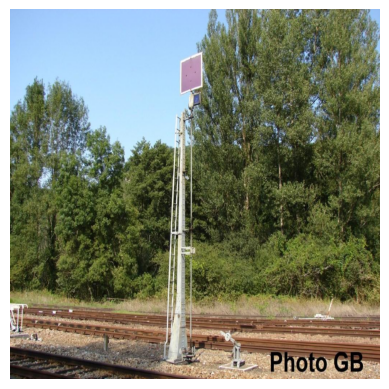

In [13]:
for img in next(iter(train_loader)):
    visualize_item(img)
    break

### Model 

Definition of Generator and Discriminator. 



In [19]:
# Residual Block used in the Generator

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


# Generator

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]
        
        # Encoder
        in_features = 16
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(
                            in_channels=in_features,
                            out_channels=out_features,
                            kernel_size=3,
                            stride=2,
                            padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Decoder
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(
                                    in_features,
                                    out_features,
                                    kernel_size=3,
                                    stride=2,
                                    padding=1,
                                    output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)
    


# Discriminator

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
    
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True))

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)        
        x = self.conv4(x)
        x = self.conv5(x)
        x = F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
        return x


In [30]:
# Paramerters definition
input_nc = 3
output_nc = 3

In [31]:
# Networks
net_G = Generator(input_nc, output_nc)
net_F = Generator(output_nc, input_nc)
net_Dx = Discriminator(input_nc)
net_Dy = Discriminator(output_nc)

device = torch.device(CFG.device)
net_G = net_G.to(device)
net_F = net_F.to(device)
net_Dx = net_Dx.to(device)
net_Dy = net_Dy.to(device)

num_params_G = sum(p.numel() for p in net_G.parameters() if p.requires_grad)
num_params_F = sum(p.numel() for p in net_F.parameters() if p.requires_grad)

num_params_Dx = sum(p.numel() for p in net_Dx.parameters() if p.requires_grad)
num_params_Dy = sum(p.numel() for p in net_Dy.parameters() if p.requires_grad)

print('Number of parameters for generator G: %d generator F: %d discriminator x: %d discriminator y: %d' % (num_params_G, num_params_F, num_params_Dx, num_params_Dy))

Number of parameters for generator G: 729811 generator F: 729811 discriminator x: 2764737 discriminator y: 2764737


### Training

In [23]:
def visualize_generated_images(generator, latent, epoch):
  """
  Generates and visualizes images from the given generator model.

  Args:
      generator: The generator model to use for image generation.
      num_images: The number of images to generate and visualize.
  """

  # Generate noise vector
  noise = torch.randn(CFG.train_bs, latent, device)

  # Generate fake images
  fake_images = generator(noise)

  # Normalize and convert to image format (if necessary)
  # fake_images = (fake_images - fake_images.min()) / (fake_images.max() - fake_images.min())  # Normalize
  fake_images = fake_images.detach().cpu() * 255  # Convert to 0-255 range (assuming uint8)
  fake_images = fake_images.permute(0, 2, 3, 1).to(torch.uint8)  # Permute if channels are not last
  
  plt.figure(figsize=(24, 3))
  for i in range(len(fake_images)):
    plt.subplot(1, 8, i+1)
    plt.imshow(fake_images[i])  
    plt.axis('off')
  plt.suptitle(f"Generated Images - Epoch {epoch}", fontsize=12)  # Add title
  plt.tight_layout()
  plt.show()

In [25]:
MODEL_WORKSPACE = "/home/hghallab/Dvlp/GANs/CycleGAN"
os.chdir(MODEL_WORKSPACE)
runs = sorted(os.listdir(os.path.join(MODEL_WORKSPACE, "runs")))
if len(runs) == 0:
    CURRENT_MODEL_DIR = "runs/" + "run_1"
else:
    CURRENT_MODEL_DIR = "runs/" + f"run_{int(runs[-1].split('_')[-1]) + 1}"
os.mkdir(os.path.join(MODEL_WORKSPACE, CURRENT_MODEL_DIR))

In [26]:
run = wandb.init(project='CycleGAN', 
                config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                name=f"{CURRENT_MODEL_DIR}|model-{CFG.model_name}",
                )

In [32]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [33]:
# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(net_G.parameters(), net_F.parameters()),
                                lr=CFG.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(net_Dx.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(net_Dy.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

# lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
# lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
# lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

In [18]:
# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')

# wandb.watch(generator, log_freq=100)
# wandb.watch(discriminator, log_freq=100)

start = time.time()

best_model_gen = copy.deepcopy(generator.state_dict())
best_model_disc = copy.deepcopy(discriminator.state_dict())
best_epoch     = -1
best_disc_loss = np.inf
best_gen_loss = np.inf
history = defaultdict(list)

for epoch in range(CFG.epochs):
    
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch in train_loader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)
        
        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        print("info real pred")
        real_pred = discriminator(image_batch).squeeze()
        print("info fake pred")
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            criterion(real_pred, label_real) +
            criterion(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = criterion(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches

    visualize_generated_images(generator, latent, epoch)
    
    # # deep copy the model
    # if disc_loss_avg[-1] >= best_disc_loss:
    #     print(f"{c_}Valid Score Improved ({best_disc_loss:0.4f} ---> {disc_loss_avg[-1]:0.4f})")
    #     best_disc_loss   = disc_loss_avg[-1]
    #     best_epoch   = epoch
    #     run.summary["Best Disriminator Loss"]    = best_disc_loss
    #     run.summary["Corresponding Generator Loss"] = gen_loss_avg[-1] 
    #     run.summary["Best Epoch"]   = best_epoch
    #     best_model_gen = copy.deepcopy(generator.state_dict())
    #     best_model_disc = copy.deepcopy(discriminator.state_dict())
    #     # PATH = f"best_epoch-{fold:02d}.bin"
    #     PATH = f"{CURRENT_MODEL_DIR}/best_epoch.bin"
    #     torch.save(generator.state_dict(), PATH)
    #     torch.save(discriminator.state_dict(), PATH)        
    #     # Save a model file from the current directory
    #     wandb.save(PATH)
    #     print(f"Model Saved{sr_}")
    
    # # Log the metrics
    # wandb.log({"Discriminator Loss": disc_loss_avg[-1], 
    #            "Generator Loss": gen_loss_avg[-1],})
    
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, CFG.epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

    
history['Discriminator Loss'] = disc_loss_avg
history['Generator Loss'] = gen_loss_avg

    
end = time.time()

time_elapsed = end - start
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
print("Best Score: {:.4f}".format(best_disc_loss))

# run.finish()


Training ...
gen torch.Size([8, 100, 1, 1])
gen torch.Size([8, 1024, 4, 4])
gen torch.Size([8, 512, 8, 8])
gen torch.Size([8, 256, 16, 16])
gen torch.Size([8, 128, 32, 32])
gen torch.Size([8, 3, 64, 64])
gen torch.Size([8, 3, 128, 128])
gen torch.Size([8, 3, 256, 256])
gen torch.Size([8, 3, 512, 512])
gen torch.Size([8, 3, 1024, 1024])
info real pred
input shape torch.Size([8, 3, 1024, 1024])
after layer one torch.Size([8, 128, 512, 512])
after layer two torch.Size([8, 256, 256, 256])
after layer three torch.Size([8, 512, 128, 128])
after layer four torch.Size([8, 1024, 64, 64])
after layer 5 torch.Size([8, 1024, 32, 32])
after layer 6 torch.Size([8, 1024, 16, 16])
after layer 7 torch.Size([8, 1024, 8, 8])
after layer 8 torch.Size([8, 1024, 4, 4])
output shape, five torch.Size([8, 1, 1, 1]) end
info fake pred
input shape torch.Size([8, 3, 1024, 1024])
after layer one torch.Size([8, 128, 512, 512])
after layer two torch.Size([8, 256, 256, 256])
after layer three torch.Size([8, 512, 128,

In [27]:
import gc
gc.collect()

345

In [50]:
import math
31490048/64/64

7688.0